In [1]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time

np.random.seed(42)

<module 'operator_calculations' from '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/operator_calculations.py'>

In [2]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data+'filtered_jmpool_kin.h5','r')
lengths = np.array(f['MetaData/lengths_data'],dtype=int)

##shapes are n_fish, max_n_bouts,dim of variable
time_Bout_allcond = ma.array(f['times_bouts']) #raw times bouts

f.close()

In [3]:
time_Bout_allcond[time_Bout_allcond == 0] = ma.masked

In [4]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[453,463],[121,133],[49,109],[22,49],[163,193],[109,121],
                           [133,164],[443,453],[0,22],
                           [193,258],[304,387],[258,273],[273,304],
                           [387,443]])

In [5]:
conditions = np.zeros((np.max(condition_recs),2),dtype='object')
for k in range(len(condition_recs)):
    t0,tf = condition_recs[k]
    conditions[t0:tf,0] = np.arange(t0,tf)
    conditions[t0:tf,1] = [condition_labels[k] for t in range(t0,tf)]

In [6]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data + 'kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()

In [7]:
to_mask = 1300
maxL = np.max(lengths_all)

labels_fish[labels_fish == to_mask] = ma.masked

In [8]:
## Select Dataset
np.random.seed(42)
seeds = np.random.randint(0,10000,100)
delay_range = np.arange(1,20,1)
dt = 1
div= 463
n_modes=50
labels_all= ma.concatenate(labels_fish,axis=0)
print(labels_fish.shape)

(463, 11651)


In [9]:
P_ensemble = np.load(path_to_filtered_data + 'P_ensemble_ex8_N1200_s8684.npy')

In [10]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

In [11]:
# Load eigenfunctions

# eigfunctions = np.load(path_to_filtered_data + 'eigfs_n1200.npy')
phi1 = eigfunctions[:,1]
phi2 = eigfunctions[:,2]
phi3 = eigfunctions[:,3]

# Uncomment to discover eigenfunctions and eigenvalues from ensemble transition matrix. 
# The estimation of eigenvalues is done through ARPACK, which is stochastic in nature. 
# This can result in the eigenvectors flipping sign. 
# If that happens, you can change the random seed in op_calc.sorted_spectrum()

# from scipy.sparse import diags,identity,coo_matrix, csr_matrix
# P_ensemble = csr_matrix(P_ensemble)

# import msmtools.estimation as msm_estimation
# delay = 3
# dt = 1
# print(delay)
# # lcs_ensemble,P_ensemble = op_calc.transition_matrix(labels_all,delay,return_connected=True)
# lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
# inv_measure = op_calc.stationary_distribution(P_ensemble)
# final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)
# R = op_calc.get_reversible_transition_matrix(P_ensemble)
# eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=123) 
# sorted_indices = np.argsort(eigvals.real)[::-1]
# eigvals = eigvals[sorted_indices][1:].real
# eigvals[np.abs(eigvals-1)<1e-12] = np.nan
# eigvals[eigvals<1e-12] = np.nan
# t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
# eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
# eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
# eigfunctions_traj[final_labels.mask] = ma.masked

3


In [15]:
# Load eigenfunctions  
eigfunctions = np.load(path_to_filtered_data + 'eigfs_n1200.npy')
phi1 = eigfunctions[:,1]
phi2 = eigfunctions[:,2]
phi3 = eigfunctions[:,3]

In [16]:
split_locs = []
distorted_eigfs = np.zeros((eigfunctions.shape[0], eigfunctions.shape[1]-1))
for i in range(1,eigfunctions.shape[1]):
    phi = eigfunctions[:,i]
    _,_,_,split_idx,_ = op_calc.optimal_partition(phi,inv_measure,P_ensemble,return_rho=True)

    sort_range = np.sort(phi)
    neg_range = np.linspace(-1,0, len(sort_range[0:split_idx]))
    pos_range = np.linspace(0,1,len(sort_range[split_idx:]))
    distort_r = np.hstack([neg_range,pos_range])
    distort = np.zeros(phi.shape)

    pos = [np.where(phi == a)[0][0] for a in np.sort(phi)]

    for j in range(phi.shape[0]):
        distort[pos[j]] = distort_r[j]

    distorted_eigfs[:,i-1] = distort
    split_locs.append(split_idx)

In [17]:
distorted_trajs = ma.array(distorted_eigfs)[final_labels,:]
distorted_trajs[final_labels.mask] = ma.masked

distorted_fish = distorted_trajs.reshape(labels_fish.shape[0], labels_fish.shape[1], -1)

## Inter-Bout intervals along long-lived modes

In [127]:
split_locs = []
distorted_eigfs = np.zeros((eigfunctions.shape[0], eigfunctions.shape[1]-1))
for i in range(1,eigfunctions.shape[1]):
    phi = eigfunctions[:,i]
    _,_,_,split_idx,_ = op_calc.optimal_partition(phi,inv_measure,P_ensemble,return_rho=True)

    sort_range = np.sort(phi)
    neg_range = np.linspace(-1,0, len(sort_range[0:split_idx]))
    pos_range = np.linspace(0,1,len(sort_range[split_idx:]))
    distort_r = np.hstack([neg_range,pos_range])
    distort = np.zeros(phi.shape)

    pos = [np.where(phi == a)[0][0] for a in np.sort(phi)]

    for j in range(phi.shape[0]):
        distort[pos[j]] = distort_r[j]

    distorted_eigfs[:,i-1] = distort
    split_locs.append(split_idx)

In [128]:
time_Bout_allcond[time_Bout_allcond == 0] = ma.masked

In [130]:
time_Bout_allcond = time_Bout_allcond[:,:maxL,:]

In [131]:
#IBI calculation

ibi_fish = (time_Bout_allcond[:,1:,0]-time_Bout_allcond[:,:-1,1])/700.
ibi_fish2 = ma.zeros(labels_fish[:].shape)
ibi_fish2[:,1:] = ibi_fish
ibi_fish2[:,0] = ma.masked
ibi_all = ma.concatenate(ibi_fish2, axis=0)

# ibis_embed = embed.trajectory_matrix(ibi_all[:,np.newaxis], K=4)

In [132]:
ibi_labels = []

ibi_labels = np.asarray([ma.median(ibi_all[ma.concatenate(labels_fish[:,:maxL],axis=0)==kl]) 
                         for kl in range(1200)])

In [133]:
phi_1 = distorted_eigfs[:,0]
phi_2 = distorted_eigfs[:,1]
phi_3 = distorted_eigfs[:,2]

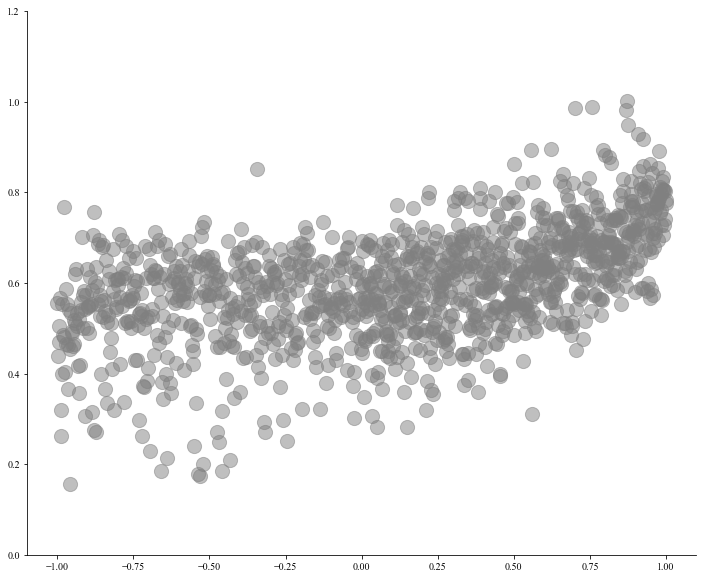

In [147]:
## Kinetic Maps with diffusion distances
fig, ax = plt.subplots(1,1,figsize=(12,10))

im = ax.scatter(phi_1[:],ibi_labels,s=200,c='grey', alpha=0.5)
ax.set_ylim(0,1.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.axis('off')
# 
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/phi1_ibi.pdf')


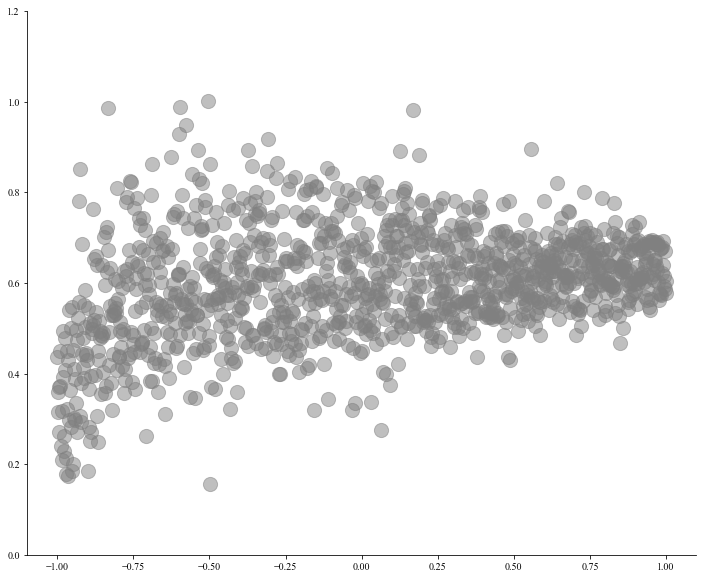

In [149]:
## Kinetic Maps with diffusion distances
fig, ax = plt.subplots(1,1,figsize=(12,10))

im = ax.scatter(phi_2[:],ibi_labels,s=200,c='grey',alpha=0.5)
ax.set_ylim(0,1.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.axis('off')
# 
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/phi2_ibi.pdf')


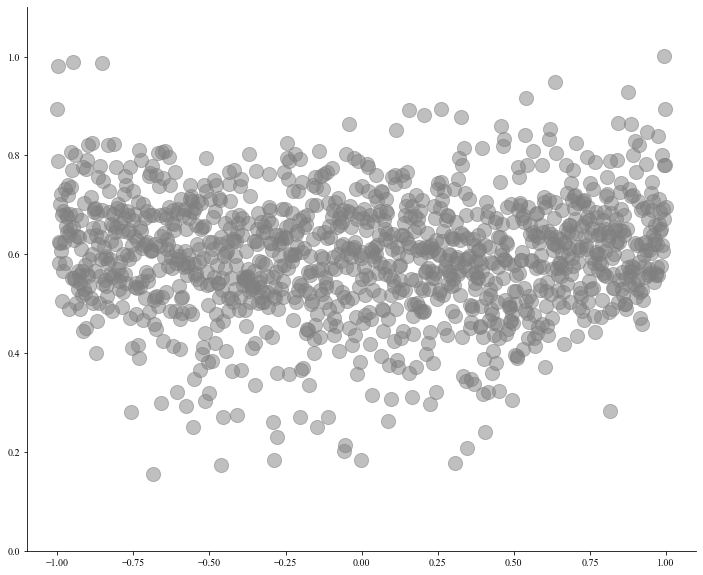

In [150]:
## Kinetic Maps with diffusion distances
fig, ax = plt.subplots(1,1,figsize=(12,10))

im = ax.scatter(phi_3[:],ibi_labels,s=200,c='grey',alpha=0.5)
# fig.colorbar(im)
ax.set_ylim(0,1.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.axis('off')
# 
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/phi3_ibi.pdf')

## Exploring non-stationarity

In [12]:
time_bouts = time_Bout_allcond[:,:maxL,:]

In [13]:
def get_symbol_seq(eigtraj):
    symb_seq = ma.zeros(eigtraj.shape[0],dtype=int)
    symb_seq[eigtraj>0]=1
    symb_seq[eigtraj.mask] = ma.masked
    return symb_seq

In [19]:
st_colors = ['#D04D49','#1F50A3',]

3 min Light<->Dark(5x5cm) 30.355619047619047 30.35562411221591


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


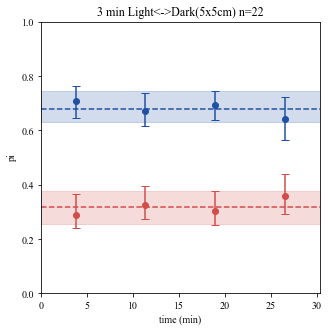

Dark (5x5cm) 35.73007619047619 35.73007507324219


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


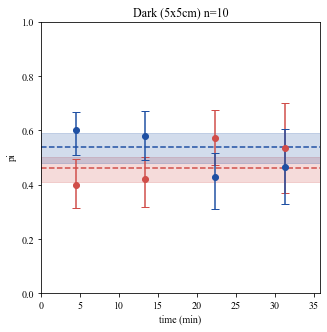

Dark_Transitions(5x5cm) 129.4864761904762 129.48646375868054


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


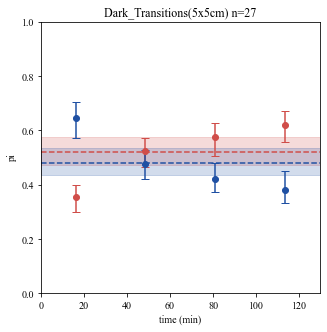

Light (1x5cm) 35.55333333333333 35.55333964029948


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


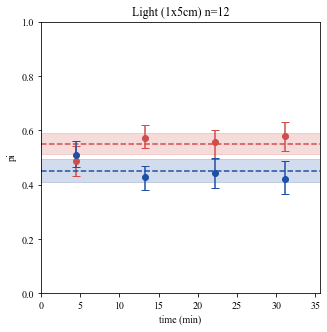

Light (5x5cm) 30.12312142857143 30.1231201171875


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


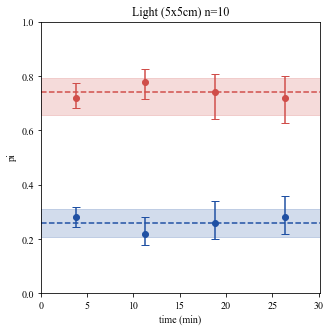

Light RW. (2.5x2.5cm) 22.831964285714285 22.831965855189733


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


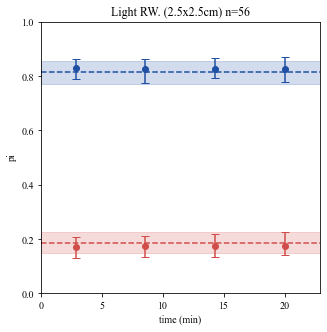

Looming(5x5cm) 57.721473015873016 57.72147216796875


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


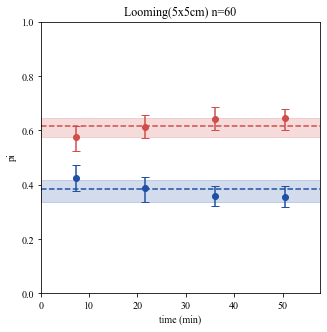

Optokinetic Response (5x5cm) 20.655615975422428 20.655614053049394


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


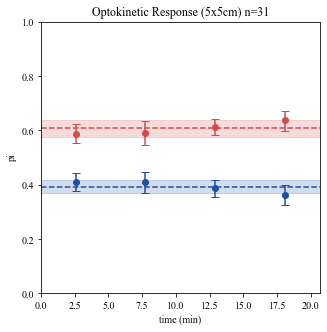

Optomotor Response (1x5cm) 31.412821428571426 31.412821451822918


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


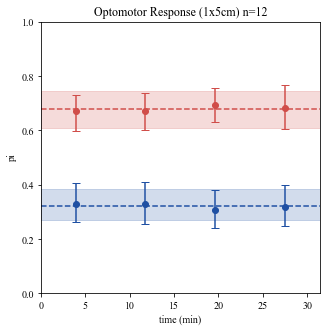

Phototaxis 30.83000985221675 30.83001288052263


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


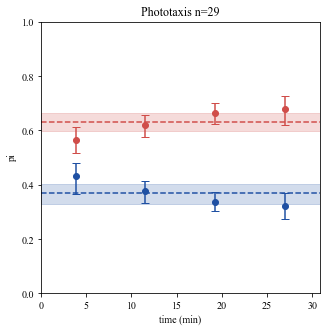

Prey Capture Param. (2.5x2.5cm) 22.198004395604396 22.198003680889425


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


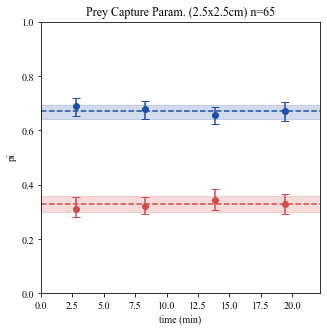

Prey Capture Param. RW. (2.5x2.5cm) 23.281576592082615 23.281579442771083


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


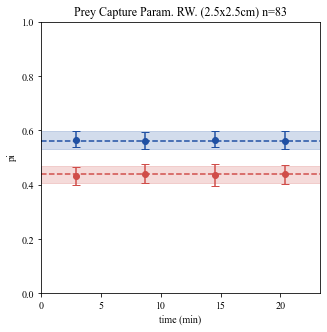

Prey Capture Rot.(2.5x2.5cm) 72.96400634920634 72.96399739583333


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


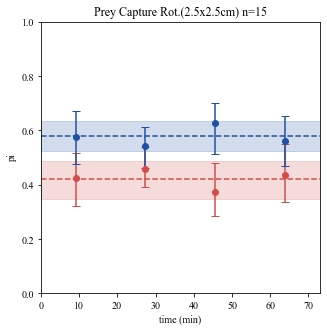

Prey capture Rot. RW. (2.5x2.5cm) 66.9063594470046 66.90636025705645


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


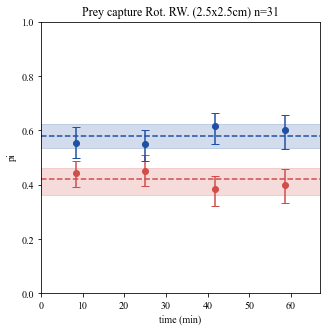

In [20]:
nwindows=4
for cl in range(len(np.unique(conditions[:,1]))):
    condition = np.unique(conditions[:,1])[cl]
    sel = conditions[:,1]==condition
    phis_sel = distorted_fish[sel]
    nfish_sel = sel.sum()
    times_sel = time_bouts[sel]
    tmax = np.mean(np.max(times_sel[:,:,1],axis=1))
    print(condition,tmax/700/60,np.mean(np.max(times_sel[:,:,1],axis=1)/700/60))

    wsize = int(np.floor(np.ceil(tmax)/nwindows))
    trange = np.linspace(0,tmax,nwindows+1)[:-1]
    pi_times = ma.zeros((phis_sel.shape[0],len(trange),2))
    for kf in range(phis_sel.shape[0]):
        for kt,t0 in enumerate(trange):
            sel_t = np.logical_and(times_sel[kf,:,0]>t0,times_sel[kf,:,0]<=t0+wsize)
            cluster_traj =get_symbol_seq(phis_sel[kf,sel_t,0])
            if ma.count(cluster_traj)>50:
                    _,counts = np.unique(cluster_traj.compressed(),return_counts=True)
                    pi = counts/counts.sum()
                    for ks,state in enumerate(np.unique(cluster_traj.compressed())):
                        pi_times[kf,kt,state] = pi[ks]
            else:
                pi_times[kf,kt,0] = ma.masked
                pi_times[kf,kt,1] = ma.masked
    pi_times=ma.masked_invalid(pi_times)
    sel = (pi_times.mask[:,:,0]).sum(axis=0)>pi_times.shape[0]-2
    pi_times[:,sel,:]=ma.masked
    
    
    pi_total = pi_times.mean(axis=1)
    
    centers_t = np.hstack([(trange[1:]+trange[:-1])/2,(trange[-1]+trange[-1]+wsize)/2])
    
    plt.figure(figsize=(5,5))
    plt.title(condition+' n={}'.format(nfish_sel))
    for ks in range(2):
        mean_total,cil_total,ciu_total = stats.bootstrap(pi_total[:,ks],n_times=100)
        plt.axhline(mean_total,c=st_colors[ks],ls='--')
        plt.axhspan(cil_total,ciu_total,color=st_colors[ks],alpha=.2)

        mean,cil,ciu = stats.bootstrap(pi_times[:,:,ks],n_times=100)
        
        plt.errorbar(((centers_t/700)/60),mean,yerr = [mean-cil,ciu-mean],capsize=4,fmt='o',c=st_colors[ks])
    plt.xlim(trange[0]/700/60,(trange[-1]+wsize)/700/60)
    plt.ylim(0,1)
    plt.ylabel('pi')
    plt.xlabel('time (min)')
#     plt.savefig('nonstationarity_pi_4windows_{}.pdf'.format(condition))
    plt.show()